<a href="https://colab.research.google.com/github/Saria-Alashry/Alashry/blob/%D8%A7%D9%84%D9%83%D9%88%D8%B1%D8%B3-%D8%A7%D9%84%D9%85%D9%81%D8%B5%D9%84-%D9%81%D9%8A-%D8%A7%D9%84%D8%B0%D9%83%D8%A7%D8%A1-%D8%A7%D9%84%D8%A7%D8%B5%D8%B7%D9%86%D8%A7%D8%B9%D9%8A-%D9%88%D9%85%D8%B3%D8%A7%D8%A8%D9%82%D8%A9-%D8%A8%D8%B1%D9%85%D8%AC%D8%A9-50-%D8%A7%D9%84%D9%81-%D8%AC%D9%86%D9%8A%D9%87/week7_probabilistic_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir="rtl" style="text-align: right; font-size: 28px; font-weight: bold; background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); padding: 20px; border-radius: 10px; margin-bottom: 20px;">

# Week 7: Probabilistic Machine Learning

 بعد ما اتمرنا على مشكلة حقيقية وعملنا pipeline
  دلوقتي يلا بينا
 نشوف النظرة الاحتمالية على ال Machine Learning


في Lectures 11 و 12 اتعلمت النظرية - النهاردة هنطبقها عملي بإذن الله!

هنشوف إزاي Bayes Theorem بتشتغل في ال Classification  وكمان إزاي نفكر في Cost Functions من منظور احتمالي

</div>

## Overview

**Instructor:** Dr. Mahmoud Eid (m.eid@fci-cu.edu.eg)

**Estimated Time:** 2-3 hours

**What You'll Learn:**

**Part 1: Bayesian Classification**
- Naive Bayes with Gaussian assumption
- Kernel Density Estimation (KDE) for non-parametric density
- t-distributions

**Part 2: Probabilistic Cost Functions**
- MSE as Maximum Likelihood with Gaussian noise
- Why Laplace distribution is robust to outliers
- PyTorch implementation of robust regression

**Prerequisites:** PyTorch basics, Week 3-4 (regression, classification)


---

## Setup and Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LinearRegression
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('dark_background')
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

All libraries imported successfully!
PyTorch version: 2.9.0+cpu


---

# Part 1: Bayesian Classification

We use **Bayes' Theorem** to compute class probabilities from feature likelihoods (covered in Lecture 11).

The "naive" assumption: features are independent given the class.

## Load the Data

We'll use a binary classification dataset with 50 features.

In [6]:
# Load training and test data
train_df = pd.read_excel('/content/train_data2.xlsx', engine='openpyxl')
test_df = pd.read_excel('/content/test_data2.xlsx', engine='openpyxl')

# Separate features and target
X_train = train_df.drop('target', axis=1).values
y_train = train_df['target'].values
X_test = test_df.drop('target', axis=1).values
y_test = test_df['target'].values

print(f"Training data: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test data: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"\nClass distribution (train): {np.bincount(y_train)}")
print(f"Class distribution (test): {np.bincount(y_test)}")

Training data: 700 samples, 50 features
Test data: 300 samples, 50 features

Class distribution (train): [351 349]
Class distribution (test): [149 151]


## Z-Score Normalization

Normalize the features so they have mean 0 and std 1.

In [7]:
# Z-score normalization (fit on train, apply to both)
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
std[std == 0] = 1  # Avoid division by zero

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

print(f"Normalized {X_train.shape[1]} features")
print(f"Feature 0 - Mean: {X_train_scaled[:, 0].mean():.4f}, Std: {X_train_scaled[:, 0].std():.4f}")

Normalized 50 features
Feature 0 - Mean: 0.0000, Std: 1.0000


---

## Demo 1: Gaussian Naive Bayes (From Scratch)

We assume each feature follows a **Gaussian distribution** within each class. Estimate mean and variance from training data.

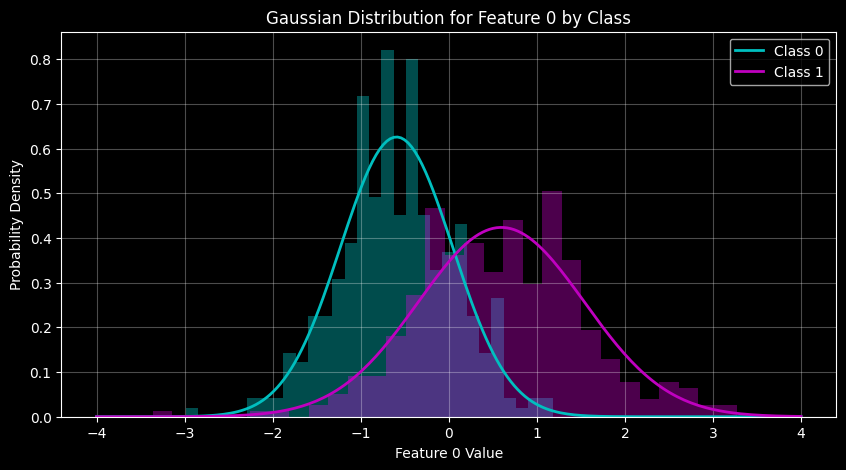

In [8]:
def estimate_probability_gaussian(x_value, data):
    """
    Estimate probability using Gaussian distribution.

    Returns:
    - Probability density at x_value
    """
    eps = 1e-9
    mean = np.mean(data)
    var = np.var(data) + eps
    coef = 1.0 / np.sqrt(2 * np.pi * var)
    exp_term = np.exp(-((x_value - mean) ** 2) / (2 * var))
    return coef * exp_term

# Example: visualize for one feature
feature_idx = 0
class_0_data = X_train_scaled[y_train == 0, feature_idx]
class_1_data = X_train_scaled[y_train == 1, feature_idx]

x_range = np.linspace(-4, 4, 200)
prob_0 = [estimate_probability_gaussian(x, class_0_data) for x in x_range]
prob_1 = [estimate_probability_gaussian(x, class_1_data) for x in x_range]

plt.figure(figsize=(10, 5))
plt.plot(x_range, prob_0, 'c-', linewidth=2, label='Class 0')
plt.plot(x_range, prob_1, 'm-', linewidth=2, label='Class 1')
plt.hist(class_0_data, bins=30, alpha=0.3, color='cyan', density=True)
plt.hist(class_1_data, bins=30, alpha=0.3, color='magenta', density=True)
plt.xlabel('Feature 0 Value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution for Feature 0 by Class')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [11]:
def naive_bayes_fit_predict(X_train, y_train, X_test, method='gaussian', bandwidth=0.5):
    """
    Naive Bayes classifier with Gaussian or KDE likelihood estimation.

    Returns:
    - probas: Predicted probabilities for each class
    - priors: Prior probabilities
    - classes: Unique class labels
    """
    classes = np.unique(y_train)
    n_samples = X_test.shape[0]
    n_features = X_train.shape[1]
    n_classes = len(classes)

    class_data = {}
    priors = {}
    for c in classes:
        X_c = X_train[y_train == c]
        class_data[c] = X_c
        priors[c] = len(X_c) / len(y_train)

    log_probas = np.zeros((n_samples, n_classes))

    for i, x in enumerate(X_test):
        for j, c in enumerate(classes):
            log_posterior = np.log(priors[c] + 1e-9)

            for feature_idx in range(n_features):
                feature_value = x[feature_idx]
                feature_data = class_data[c][:, feature_idx]

                if method == 'gaussian':
                    likelihood = estimate_probability_gaussian(feature_value, feature_data)
                elif method == 'kde':
                    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
                    kde.fit(feature_data.reshape(-1, 1))
                    log_prob = kde.score_samples([[feature_value]])
                    likelihood = np.exp(log_prob[0])

                log_posterior += np.log(likelihood + 1e-9)

            log_probas[i, j] = log_posterior

    # Convert to probabilities (softmax-like normalization)
    max_log_proba = np.max(log_probas, axis=1, keepdims=True)
    probas = np.exp(log_probas - max_log_proba)
    # as we mentioned in lecture 11
    # we can subtract any constant (here we use the closest to zero to anchor) from all your log scores, and the final normalized probabilities will be exactly the same
    probas = probas / np.sum(probas, axis=1, keepdims=True)

    return probas, priors, classes

print("Naive Bayes function defined!")

Naive Bayes function defined!


In [12]:
print("="*60)
print("GAUSSIAN NAIVE BAYES (From Scratch)")
print("="*60)

# Predict on test set
probas_gauss, priors, classes = naive_bayes_fit_predict(
    X_train_scaled, y_train, X_test_scaled, method='gaussian'
)

# Evaluate
test_auc_gauss = roc_auc_score(y_test, probas_gauss[:, 1])
predictions = np.argmax(probas_gauss, axis=1)
test_acc_gauss = accuracy_score(y_test, predictions)

print(f"\nPriors: Class 0 = {priors[0]:.3f}, Class 1 = {priors[1]:.3f}")
print(f"Test AUC: {test_auc_gauss:.4f}")
print(f"Test Accuracy: {test_acc_gauss:.4f}")

GAUSSIAN NAIVE BAYES (From Scratch)

Priors: Class 0 = 0.501, Class 1 = 0.499
Test AUC: 1.0000
Test Accuracy: 1.0000


---

## Demo 2: KDE Naive Bayes

**Kernel Density Estimation (KDE)** - non-parametric density estimation. Places a kernel at each data point instead of assuming a specific distribution.

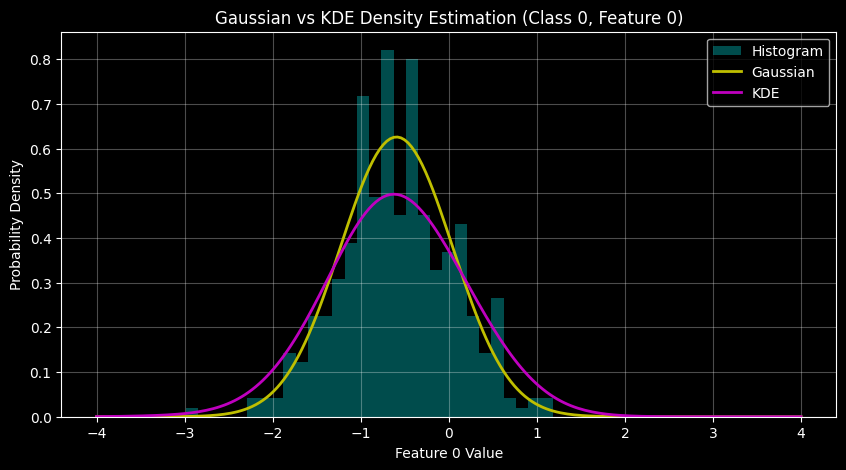

In [13]:
# Visualize KDE vs Gaussian for one feature
feature_idx = 0
class_0_data = X_train_scaled[y_train == 0, feature_idx]

# Fit KDE
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(class_0_data.reshape(-1, 1))

x_range = np.linspace(-4, 4, 200)
kde_density = np.exp(kde.score_samples(x_range.reshape(-1, 1)))
gauss_density = [estimate_probability_gaussian(x, class_0_data) for x in x_range]

plt.figure(figsize=(10, 5))
plt.hist(class_0_data, bins=30, alpha=0.3, color='cyan', density=True, label='Histogram')
plt.plot(x_range, gauss_density, 'y-', linewidth=2, label='Gaussian')
plt.plot(x_range, kde_density, 'm-', linewidth=2, label='KDE')
plt.xlabel('Feature 0 Value')
plt.ylabel('Probability Density')
plt.title('Gaussian vs KDE Density Estimation (Class 0, Feature 0)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [14]:
print("="*60)
print("KDE NAIVE BAYES")
print("="*60)

# Predict on test set
probas_kde, _, _ = naive_bayes_fit_predict(
    X_train_scaled, y_train, X_test_scaled, method='kde', bandwidth=0.5
)

# Evaluate
test_auc_kde = roc_auc_score(y_test, probas_kde[:, 1])
predictions_kde = np.argmax(probas_kde, axis=1)
test_acc_kde = accuracy_score(y_test, predictions_kde)

print(f"\nBandwidth: 0.5")
print(f"Test AUC: {test_auc_kde:.4f}")
print(f"Test Accuracy: {test_acc_kde:.4f}")

KDE NAIVE BAYES

Bandwidth: 0.5
Test AUC: 1.0000
Test Accuracy: 1.0000


---

## Demo 3: Sklearn Comparison

Let's compare our implementation with sklearn's `GaussianNB`.

In [15]:
print("="*60)
print("SKLEARN GaussianNB (Comparison)")
print("="*60)

model = GaussianNB()
model.fit(X_train_scaled, y_train)

probas_sklearn = model.predict_proba(X_test_scaled)
test_auc_sklearn = roc_auc_score(y_test, probas_sklearn[:, 1])
test_acc_sklearn = accuracy_score(y_test, model.predict(X_test_scaled))

print(f"\nTest AUC: {test_auc_sklearn:.4f}")
print(f"Test Accuracy: {test_acc_sklearn:.4f}")

SKLEARN GaussianNB (Comparison)

Test AUC: 1.0000
Test Accuracy: 1.0000


---

## The t-Distribution: Heavier Tails than Gaussian

The **Student's t-distribution** has heavier tails than Gaussian - controlled by **degrees of freedom (df)**: lower df = heavier tails.

Heavier tails means that it gives a higher likelihood to outliers compared to normal distribution so it models them better.

Think of it in this way:

When a normal distribution gets an outlier the model "panics" and shifts the line (the mean) toward the outlier to increase that probability from 0.000000001 to something "reasonable" like 0.01, because it originally got very low likelihood for outliersand because of that the model destroys the fit for all points just to explain the "impossible" point.

The t-distribution and Laplace (Heavy Tails), They accept that such outlier can be obtained every now and then. A value this far away has a probability of 0.05. That’s low, but it happens occasionally. I don't need to change my worldview just because of one rare event.

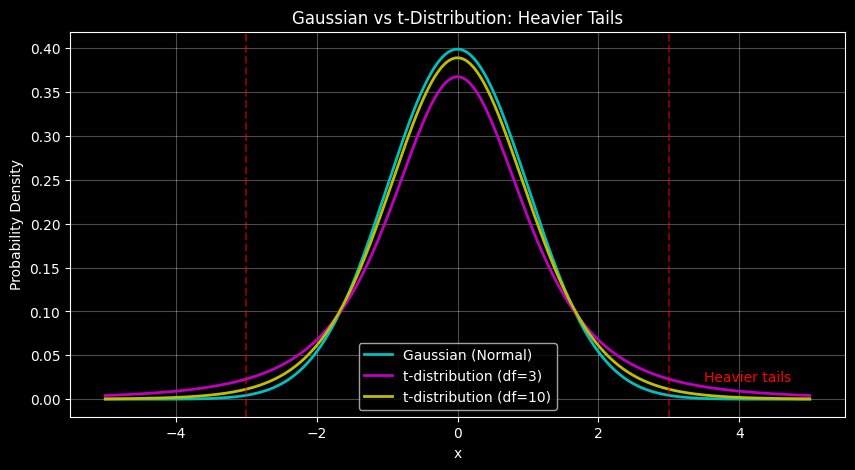

In [16]:
# Visualize t-distribution vs Gaussian
x_range = np.linspace(-5, 5, 200)

gaussian = stats.norm.pdf(x_range, 0, 1)
t_df3 = stats.t.pdf(x_range, df=3, loc=0, scale=1)
t_df10 = stats.t.pdf(x_range, df=10, loc=0, scale=1)

plt.figure(figsize=(10, 5))
plt.plot(x_range, gaussian, 'c-', linewidth=2, label='Gaussian (Normal)')
plt.plot(x_range, t_df3, 'm-', linewidth=2, label='t-distribution (df=3)')
plt.plot(x_range, t_df10, 'y-', linewidth=2, label='t-distribution (df=10)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gaussian vs t-Distribution: Heavier Tails')
plt.legend()
plt.grid(alpha=0.3)

# Highlight tails
plt.axvline(x=3, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=-3, color='red', linestyle='--', alpha=0.5)
plt.annotate('Heavier tails', xy=(3.5, 0.02), fontsize=10, color='red')
plt.show()

---

# Part 2: Probabilistic Cost Functions

**MSE** assumes errors follow a **Gaussian distribution** (thin tails).


## Create Synthetic Data with Outliers

**Note:** Don't worry about this data generation code - it's just to create demo data.

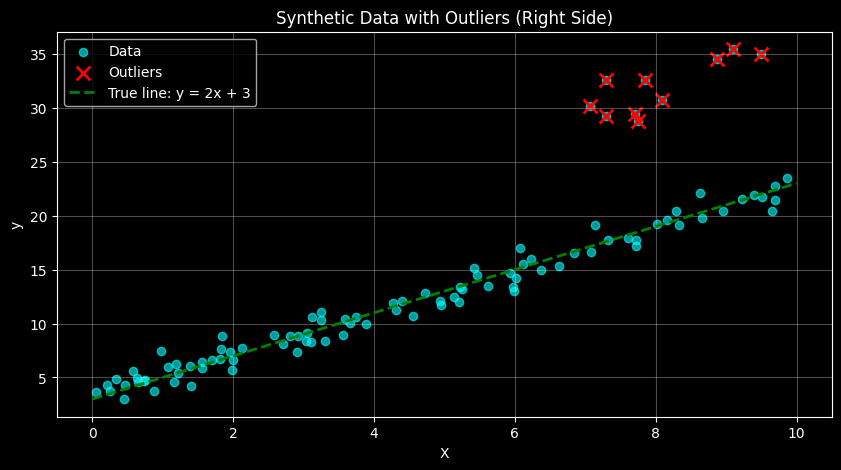

Total samples: 100, Outliers: 10


In [17]:
# Create synthetic linear data
np.random.seed(42)
n_samples = 100

# True relationship: y = 2x + 3
X_reg = np.random.uniform(0, 10, n_samples)
y_clean = 2 * X_reg + 3 + np.random.normal(0, 1, n_samples)

# Add outliers (10% of data)
n_outliers = 10
# Select indices where X > 7 (right side of the data)
right_side_mask = X_reg > 7
right_side_indices = np.where(right_side_mask)[0]
outlier_indices = np.random.choice(right_side_indices, min(n_outliers, len(right_side_indices)), replace=False)

y_with_outliers = y_clean.copy()
y_with_outliers[outlier_indices] += np.random.uniform(10, 15, len(outlier_indices))

# Visualize
plt.figure(figsize=(10, 5))
plt.scatter(X_reg, y_with_outliers, c='cyan', alpha=0.6, label='Data')
plt.scatter(X_reg[outlier_indices], y_with_outliers[outlier_indices],
            c='red', s=100, marker='x', linewidth=2, label='Outliers')
plt.plot([0, 10], [3, 23], 'g--', linewidth=2, label='True line: y = 2x + 3')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Data with Outliers (Right Side)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Total samples: {n_samples}, Outliers: {len(outlier_indices)}")

## Demo: Linear Regression with MSE (Gaussian Assumption)

In [18]:
from sklearn.linear_model import LinearRegression

lr_mse = LinearRegression()
lr_mse.fit(X_reg.reshape(-1, 1), y_with_outliers)

y_pred_mse = lr_mse.predict(X_reg.reshape(-1, 1))

# Compute MSE and estimated variance
residuals_mse = y_with_outliers - y_pred_mse
mse = np.mean(residuals_mse ** 2)

print("LINEAR REGRESSION WITH MSE")
print("="*50)
print(f"Fitted: y = {lr_mse.coef_[0]:.3f}x + {lr_mse.intercept_:.3f}")
print(f"True:   y = 2.000x + 3.000")
print(f"\nMSE: {mse:.3f}")

LINEAR REGRESSION WITH MSE
Fitted: y = 2.438x + 2.200
True:   y = 2.000x + 3.000

MSE: 13.980


LINEAR REGRESSION WITH MSE
Fitted: y = 2.438x + 2.200
True:   y = 2.000x + 3.000

MSE: 13.980
Estimated Variance Range: [4.322, 73.804]


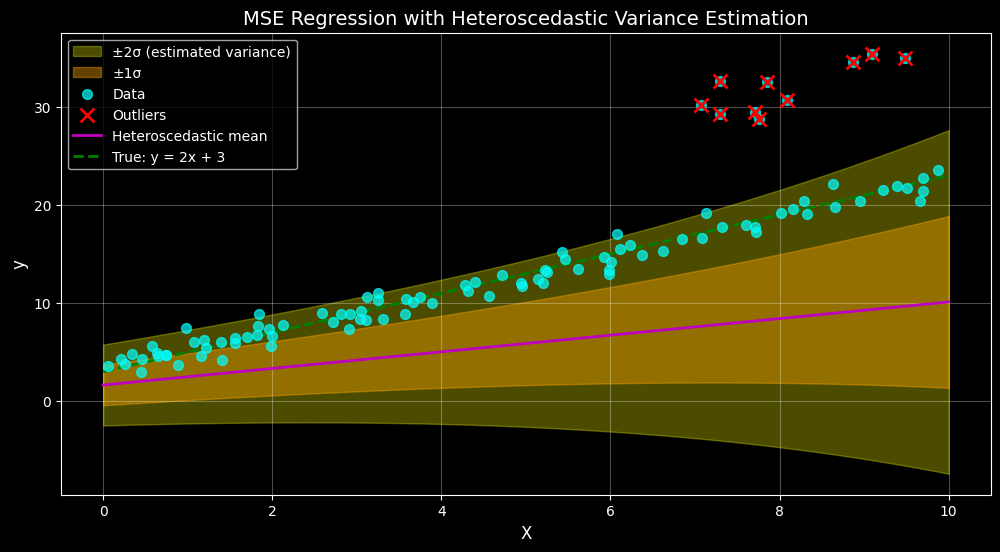

In [19]:
lr_mse = LinearRegression()
lr_mse.fit(X_reg.reshape(-1, 1), y_with_outliers)

y_pred_mse = lr_mse.predict(X_reg.reshape(-1, 1))

residuals_mse = y_with_outliers - y_pred_mse
mse = np.mean(residuals_mse ** 2)

# Heteroscedastic variance estimation using PyTorch
# Model predicts both mean and log-variance at each point
class HeteroscedasticModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean_layer = nn.Linear(1, 1)
        self.log_var_layer = nn.Linear(1, 1)

    def forward(self, x):
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        return mean, log_var

# Train heteroscedastic model
X_torch = torch.tensor(X_reg, dtype=torch.float32).reshape(-1, 1)
y_torch = torch.tensor(y_with_outliers, dtype=torch.float32).reshape(-1, 1)

hetero_model = HeteroscedasticModel()
optimizer_hetero = optim.Adam(hetero_model.parameters(), lr=0.01)

for epoch in range(2000):
    optimizer_hetero.zero_grad()
    mean_pred, log_var_pred = hetero_model(X_torch)

    # Negative log-likelihood loss for heteroscedastic Gaussian .. note that now we are trying to get the variance
    # as well so it remains in the equation of likelihood
    var_pred = torch.exp(log_var_pred)
    nll_loss = 0.5 * log_var_pred + 0.5 * (y_torch - mean_pred) ** 2 / var_pred
    loss = nll_loss.mean()

    loss.backward()
    optimizer_hetero.step()

# Get estimated mean and variance for plotting
x_plot = torch.linspace(0, 10, 200).reshape(-1, 1)
with torch.no_grad():
    mean_plot, log_var_plot = hetero_model(x_plot)
    mean_plot = mean_plot.numpy().flatten()


    # Note that here we do a trick that is different from what we mentioned about squaring the value to make it positive
    # this trick makes things easier and make sure that the variance will be positive: we don't limit the output of the model
    # but we assume that what it outputs (continuous) is the log of the variance because it has that -inf to inf range
    # now if that log(var) to get the variance we can do e^(log(var)) and if we take the sqrt of that we would have std
    # you can also think of it like the exponential that we used in the softmax to make the value positive
    std_plot = np.sqrt(torch.exp(log_var_plot).numpy().flatten())

x_plot_np = x_plot.numpy().flatten()

# Get variance at data points
with torch.no_grad():
    _, log_var_est = hetero_model(X_torch)
    variance_estimates = torch.exp(log_var_est).numpy().flatten()

print("LINEAR REGRESSION WITH MSE")
print("="*50)
print(f"Fitted: y = {lr_mse.coef_[0]:.3f}x + {lr_mse.intercept_:.3f}")
print(f"True:   y = 2.000x + 3.000")
print(f"\nMSE: {mse:.3f}")
print(f"Estimated Variance Range: [{variance_estimates.min():.3f}, {variance_estimates.max():.3f}]")

# Visualize with shaded variance region
plt.figure(figsize=(12, 6))

# ±2 std (95% confidence)
plt.fill_between(x_plot_np,
                 mean_plot - 2 * std_plot,
                 mean_plot + 2 * std_plot,
                 alpha=0.3, color='yellow', label='±2σ (estimated variance)')

# ±1 std (68% confidence)
plt.fill_between(x_plot_np,
                 mean_plot - std_plot,
                 mean_plot + std_plot,
                 alpha=0.4, color='orange', label='±1σ')

plt.scatter(X_reg, y_with_outliers, c='cyan', alpha=0.7, s=50, label='Data', zorder=5)
plt.scatter(X_reg[outlier_indices], y_with_outliers[outlier_indices],
            c='red', s=100, marker='x', linewidth=2, label='Outliers', zorder=6)

plt.plot(x_plot_np, mean_plot, 'm-', linewidth=2, label='Heteroscedastic mean')
plt.plot([0, 10], [3, 23], 'g--', linewidth=2, label='True: y = 2x + 3')

plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('MSE Regression with Heteroscedastic Variance Estimation', fontsize=14)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()


---

## The Laplace Distribution: Robust to Outliers

**Laplace distribution** has heavier tails than Gaussian. Using Laplace assumption leads to **MAE** (Mean Absolute Error) as the loss function.

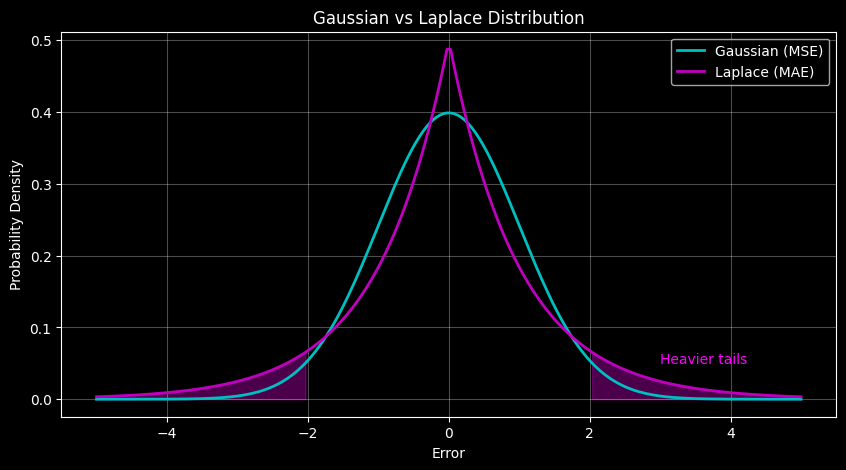

In [20]:
x_range = np.linspace(-5, 5, 200)

gaussian = stats.norm.pdf(x_range, 0, 1)
laplace = stats.laplace.pdf(x_range, 0, 1)

plt.figure(figsize=(10, 5))
plt.plot(x_range, gaussian, 'c-', linewidth=2, label='Gaussian (MSE)')
plt.plot(x_range, laplace, 'm-', linewidth=2, label='Laplace (MAE)')
plt.xlabel('Error')
plt.ylabel('Probability Density')
plt.title('Gaussian vs Laplace Distribution')
plt.legend()
plt.grid(alpha=0.3)

# Highlighting tails
plt.fill_between(x_range[x_range > 2], 0, laplace[x_range > 2], alpha=0.3, color='magenta')
plt.fill_between(x_range[x_range < -2], 0, laplace[x_range < -2], alpha=0.3, color='magenta')
plt.annotate('Heavier tails', xy=(3, 0.05), fontsize=10, color='magenta')
plt.show()

## Demo: Robust Regression with PyTorch (L1 Loss)

Using `nn.L1Loss()` which corresponds to Laplace assumption.

In [21]:
# Convert to PyTorch tensors
X_torch = torch.tensor(X_reg, dtype=torch.float32).reshape(-1, 1)
y_torch = torch.tensor(y_with_outliers, dtype=torch.float32).reshape(-1, 1)

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Model with L1 Loss (Laplace assumption)
model_laplace = LinearModel()
criterion_l1 = nn.L1Loss()  # MAE - corresponds to Laplace distribution
optimizer = optim.Adam(model_laplace.parameters(), lr=0.1)

# Training loop
losses = []
for epoch in range(1000):
    optimizer.zero_grad()
    predictions = model_laplace(X_torch)
    loss = criterion_l1(predictions, y_torch)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Get learned parameters
weight = model_laplace.linear.weight.item()
bias = model_laplace.linear.bias.item()

print("PYTORCH LINEAR REGRESSION WITH L1 LOSS (Laplace Assumption)")
print("="*50)
print(f"Fitted: y = {weight:.3f}x + {bias:.3f}")
print(f"True:   y = 2.000x + 3.000")
print(f"\nFinal MAE: {losses[-1]:.3f}")

PYTORCH LINEAR REGRESSION WITH L1 LOSS (Laplace Assumption)
Fitted: y = 1.977x + 3.278
True:   y = 2.000x + 3.000

Final MAE: 1.923


## Compare Both Methods Visually

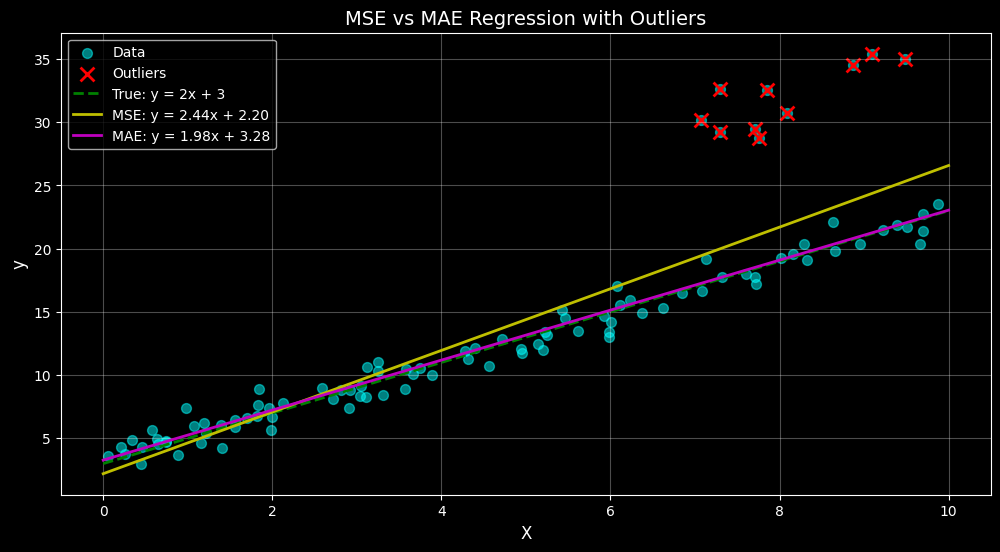


RESULTS
Method          Slope      Intercept    Slope Error 
--------------------------------------------------
True            2.000      3.000        -           
MSE             2.438      2.200        0.438       
MAE             1.977      3.278        0.023       


In [22]:
x_line = np.linspace(0, 10, 100)
y_mse_line = lr_mse.coef_[0] * x_line + lr_mse.intercept_
y_laplace_line = weight * x_line + bias
y_true_line = 2 * x_line + 3

plt.figure(figsize=(12, 6))

# Data points
plt.scatter(X_reg, y_with_outliers, c='cyan', alpha=0.5, s=50, label='Data')
plt.scatter(X_reg[outlier_indices], y_with_outliers[outlier_indices],
            c='red', s=100, marker='x', linewidth=2, label='Outliers')

# Regression lines
plt.plot(x_line, y_true_line, 'g--', linewidth=2, label=f'True: y = 2x + 3')
plt.plot(x_line, y_mse_line, 'y-', linewidth=2,
         label=f'MSE: y = {lr_mse.coef_[0]:.2f}x + {lr_mse.intercept_:.2f}')
plt.plot(x_line, y_laplace_line, 'm-', linewidth=2,
         label=f'MAE: y = {weight:.2f}x + {bias:.2f}')

plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('MSE vs MAE Regression with Outliers', fontsize=14)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

# Quantifiable comparison
print("\nRESULTS")
print("="*50)
print(f"{'Method':<15} {'Slope':<10} {'Intercept':<12} {'Slope Error':<12}")
print("-"*50)

true_slope, true_intercept = 2, 3
slope_error_mse = abs(lr_mse.coef_[0] - true_slope)
slope_error_laplace = abs(weight - true_slope)

print(f"{'True':<15} {true_slope:<10.3f} {true_intercept:<12.3f} {'-':<12}")
print(f"{'MSE':<15} {lr_mse.coef_[0]:<10.3f} {lr_mse.intercept_:<12.3f} {slope_error_mse:<12.3f}")
print(f"{'MAE':<15} {weight:<10.3f} {bias:<12.3f} {slope_error_laplace:<12.3f}")
print("="*50)

---

# Practice Exercises

<div dir="rtl" style="text-align: right; font-size: 18px; background-color: #1a1a2e; padding: 15px; border-radius: 10px;">

دلوقتي دورك! هتطبق اللي اتعلمته في تمرينين

</div>

---

## Exercise 1: Naive Bayes with t-Distribution

Research the t-distribution and implement a version of `estimate_probability` that uses it instead of Gaussian.

**Hint:** Use `scipy.stats.t.pdf(x, df, loc, scale)` where:
- `df` = degrees of freedom (try 3-10)
- `loc` = mean of the data
- `scale` = std of the data

Then run Naive Bayes with your t-distribution function and compare with Gaussian.

In [31]:
def estimate_probability_t(x_value, data, df=5):
    """
    Estimate probability using t-distribution.

    Parameters:
    - x_value: The value to compute probability for
    - data: Training data for this feature in this class
    - df: Degrees of freedom (lower = heavier tails)

    Returns:
    - Probability density at x_value
    """
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:  # Avoid division by zero, especially for constant features
        std = 1e-9 # A small epsilon
    return stats.t.pdf(x_value, df=df, loc=mean, scale=std)


def naive_bayes_t_distribution(X_train, y_train, X_test, df=5):
    """
    Naive Bayes with t-distribution likelihood.

    Complete this function to use estimate_probability_t instead of Gaussian.
    """
    classes = np.unique(y_train)
    n_samples = X_test.shape[0]
    n_features = X_train.shape[1]
    n_classes = len(classes)

    class_data = {}
    priors = {}
    for c in classes:
        X_c = X_train[y_train == c]
        class_data[c] = X_c
        priors[c] = len(X_c) / len(y_train)

    log_probas = np.zeros((n_samples, n_classes))

    for i, x in enumerate(X_test):
        for j, c in enumerate(classes):
            log_posterior = np.log(priors[c] + 1e-9)

            for feature_idx in range(n_features):
                feature_value = x[feature_idx]
                feature_data = class_data[c][:, feature_idx]

                likelihood = estimate_probability_t(feature_value, feature_data, df=df)

                log_posterior += np.log(likelihood + 1e-9)

            log_probas[i, j] = log_posterior

    # Convert to probabilities (softmax-like normalization)
    max_log_proba = np.max(log_probas, axis=1, keepdims=True)
    probas = np.exp(log_probas - max_log_proba)
    probas = probas / np.sum(probas, axis=1, keepdims=True)

    return probas

In [32]:
# Test your implementation
probas_t = naive_bayes_t_distribution(X_train_scaled, y_train, X_test_scaled, df=5)
test_auc_t = roc_auc_score(y_test, probas_t[:, 1])
test_acc_t = accuracy_score(y_test, np.argmax(probas_t, axis=1))

print("T-DISTRIBUTION NAIVE BAYES")
print("="*50)
print(f"Test AUC: {test_auc_t:.4f}")
print(f"Test Accuracy: {test_acc_t:.4f}")
print(f"\nComparison with Gaussian AUC: {test_auc_gauss:.4f}")

T-DISTRIBUTION NAIVE BAYES
Test AUC: 1.0000
Test Accuracy: 1.0000

Comparison with Gaussian AUC: 1.0000


In [33]:
# Tests for Exercise 2

# Expected true values for comparison
true_slope_ex2 = 0.5
true_intercept_ex2 = 10.0

# Check if MSE and MAE slopes and intercepts are close to expected (within a reasonable tolerance)
assert abs(slope_mse_ex2 - true_slope_ex2) < 0.5, f"MSE slope too far from true: {slope_mse_ex2:.3f}"
assert abs(intercept_mse_ex2 - true_intercept_ex2) < 3.0, f"MSE intercept too far from true: {intercept_mse_ex2:.3f}"

assert abs(slope_laplace_ex2 - true_slope_ex2) < 0.1, f"MAE slope too far from true: {slope_laplace_ex2:.3f}"
assert abs(intercept_laplace_ex2 - true_intercept_ex2) < 0.5, f"MAE intercept too far from true: {intercept_laplace_ex2:.3f}"

# Check if MAE slope is closer to the true slope than MSE slope, demonstrating robustness
mae_slope_error = abs(slope_laplace_ex2 - true_slope_ex2)
mse_slope_error = abs(slope_mse_ex2 - true_slope_ex2)

assert mae_slope_error < mse_slope_error, f"MAE ({mae_slope_error:.3f}) should be more robust than MSE ({mse_slope_error:.3f})"

print("All tests for Exercise 2 passed successfully!")

All tests for Exercise 2 passed successfully!


In [34]:
# Tests for Exercise 1

---

## Exercise 2: Robust Regression on Different Data

New synthetic dataset with:
- Different true relationship: `y = 0.5x + 10`
- 150 samples
- 15% outliers on the right side (high X values)

Then fit both gaussian and laplace assumptions.

**Note:** Don't worry about the data generation code

In [10]:
# Create new synthetic data
np.random.seed(123)
n_samples_ex2 = 150

# True relationship: y = 0.5x + 10
X_ex2 = np.random.uniform(0, 20, n_samples_ex2)
y_ex2_clean = 0.5 * X_ex2 + 10 + np.random.normal(0, 1, n_samples_ex2)

# Add 15% outliers on the RIGHT side, going UP
n_outliers_ex2 = int(0.15 * n_samples_ex2)
right_mask = X_ex2 > 15
right_indices = np.where(right_mask)[0]
outlier_idx_ex2 = np.random.choice(right_indices, min(n_outliers_ex2, len(right_indices)), replace=False)
y_ex2 = y_ex2_clean.copy()
y_ex2[outlier_idx_ex2] += np.random.uniform(8, 12, len(outlier_idx_ex2))  # All go UP

# Fit MSE Regression
lr_mse_ex2 = LinearRegression()
lr_mse_ex2.fit(X_ex2.reshape(-1, 1), y_ex2)
slope_mse_ex2 = lr_mse_ex2.coef_[0]
intercept_mse_ex2 = lr_mse_ex2.intercept_

y_pred_mse_ex2 = lr_mse_ex2.predict(X_ex2.reshape(-1, 1))
mse_ex2 = np.mean((y_ex2 - y_pred_mse_ex2) ** 2)

# Fit MAE Regression (PyTorch with L1 Loss)
X_torch_ex2 = torch.tensor(X_ex2, dtype=torch.float32).reshape(-1, 1)
y_torch_ex2 = torch.tensor(y_ex2, dtype=torch.float32).reshape(-1, 1)

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model_laplace_ex2 = LinearModel()
criterion_l1_ex2 = nn.L1Loss()
optimizer_ex2 = optim.Adam(model_laplace_ex2.parameters(), lr=0.1)

for epoch in range(1000):
    optimizer_ex2.zero_grad()
    predictions_ex2 = model_laplace_ex2(X_torch_ex2)
    loss_ex2 = criterion_l1_ex2(predictions_ex2, y_torch_ex2)
    loss_ex2.backward()
    optimizer_ex2.step()

slope_laplace_ex2 = model_laplace_ex2.linear.weight.item()
intercept_laplace_ex2 = model_laplace_ex2.linear.bias.item()
mae_ex2 = criterion_l1_ex2(model_laplace_ex2(X_torch_ex2), y_torch_ex2).item()


# Print results
print("EXERCISE 2 RESULTS")
print("="*50)
print("True relationship: y = 0.5x + 10")
print(f"MSE Fitted:   y = {slope_mse_ex2:.3f}x + {intercept_mse_ex2:.3f} (MSE: {mse_ex2:.3f})")
print(f"MAE Fitted:   y = {slope_laplace_ex2:.3f}x + {intercept_laplace_ex2:.3f} (MAE: {mae_ex2:.3f})")

EXERCISE 2 RESULTS
True relationship: y = 0.5x + 10
MSE Fitted:   y = 0.866x + 7.684 (MSE: 8.880)
MAE Fitted:   y = 0.557x + 9.587 (MAE: 1.947)


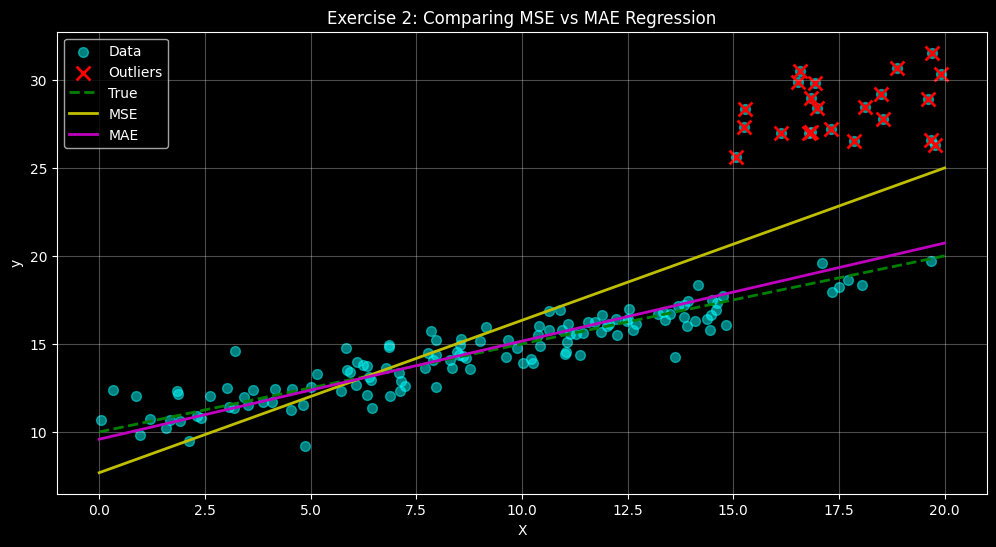

In [25]:
# Visualize your results
x_line_ex2 = np.linspace(0, 20, 100)

plt.figure(figsize=(12, 6))
plt.scatter(X_ex2, y_ex2, c='cyan', alpha=0.5, s=50, label='Data')
plt.scatter(X_ex2[outlier_idx_ex2], y_ex2[outlier_idx_ex2],
            c='red', s=100, marker='x', linewidth=2, label='Outliers')
plt.plot(x_line_ex2, 0.5 * x_line_ex2 + 10, 'g--', linewidth=2, label='True')
plt.plot(x_line_ex2, slope_mse_ex2 * x_line_ex2 + intercept_mse_ex2, 'y-', linewidth=2, label='MSE')
plt.plot(x_line_ex2, slope_laplace_ex2 * x_line_ex2 + intercept_laplace_ex2, 'm-', linewidth=2, label='MAE')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Exercise 2: Comparing MSE vs MAE Regression')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [26]:
# Tests for Exercise 2

---

<div dir="rtl" style="text-align: right; font-size: 24px; font-weight: bold; background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); padding: 20px; border-radius: 10px;">

# مبروك! خلصت Week 7 بنجاح والحمد لله

</div>

## Key Takeaways

**Part 1:** Gaussian vs KDE vs t-distribution for likelihood estimation

**Part 2:** Gaussian vs Laplace - choose based on data characteristics
